In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe
import bmi_cfe_statevars

import bmi_cfe_peturb
sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF

#sys.path.append('/home/jovyan/data/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT')
sys.path.append('C:/Users/zjbut/Documents/GitHub/NextGen---The-Simulators-/USGS/USGS_BMI_FT')

import bmi_usgs

In [2]:
print(bmi_cfe)
print(bmi_cfe_statevars)
print(bmi_cfe_peturb)

print(Bmi_da_ENKF)
print(bmi_usgs)


<module 'bmi_cfe' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe.py'>
<module 'bmi_cfe_statevars' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_statevars.py'>
<module 'bmi_cfe_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_peturb.py'>
<module 'Bmi_da_ENKF' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./Assimilation\\Bmi_da_ENKF.py'>
<module 'bmi_usgs' from 'C:\\Users/zjbut/Documents/GitHub/NextGen---The-Simulators-/USGS/USGS_BMI_FT\\bmi_usgs.py'>


In [3]:
## Open BMI's for each file
cfe_open = bmi_cfe.BMI_CFE()
cfe_peturbed = bmi_cfe_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_statevars.BMI_CFE() #true model in the end
#enkf = Bmi_da_ENKF.EnsembleKalmanFilter()
usgs = bmi_usgs.BMI_USGS()

In [4]:
## Initialize the BMI's
cfe_open.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
cfe_analysis.initialize(cfg_file='./CFE/cat_58_config_cfe.json') # I am confused what this config file should look like
#enkf.initialize(cfg_file='./Assimilation/config_enkf_cfe_basinID.json') # Need to create this still
usgs.initialize(cfg_file='C:/Users/zjbut/Documents/GitHub/NextGen---The-Simulators-/USGS/USGS_BMI_FT/usgs_config.json')



                         Date    Flow  validity
0   2015-12-01 05:00:00+00:00  1.5000       1.0
1   2015-12-01 06:00:00+00:00  1.5000       1.0
2   2015-12-01 07:00:00+00:00  1.4925       1.0
3   2015-12-01 08:00:00+00:00  1.4900       1.0
4   2015-12-01 09:00:00+00:00  1.4825       1.0
..                        ...     ...       ...
715 2015-12-31 00:00:00+00:00  1.8700       1.0
716 2015-12-31 01:00:00+00:00  1.8675       1.0
717 2015-12-31 02:00:00+00:00  1.8650       1.0
718 2015-12-31 03:00:00+00:00  1.8600       1.0
719 2015-12-31 04:00:00+00:00  1.8600       1.0

[720 rows x 3 columns]
USGS station ID 01123000


In [5]:
with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)

                    time  APCP_surface  DLWRF_surface  DSWRF_surface  \
0    2015-12-01 00:00:00           0.0     361.200012       0.000000   
1    2015-12-01 01:00:00           0.0     361.200012       0.000000   
2    2015-12-01 02:00:00           0.0     361.200012       0.000000   
3    2015-12-01 03:00:00           0.0     357.600006       0.000000   
4    2015-12-01 04:00:00           0.0     357.600006       0.000000   
..                   ...           ...            ...            ...   
715  2015-12-30 19:00:00           4.7     402.200012     163.600006   
716  2015-12-30 20:00:00           3.7     402.200012     130.300003   
717  2015-12-30 21:00:00           4.2     399.200012      80.400002   
718  2015-12-30 22:00:00           8.3     399.200012      21.000000   
719  2015-12-30 23:00:00           3.3     399.200012       0.000000   

     PRES_surface  SPFH_2maboveground  TMP_2maboveground  UGRD_10maboveground  \
0        100530.0              0.0105         287.5000

In [6]:
# Make empty matrices for plotting
cfeOpen = []
cfePeturbed = []
#sim = []
#obs = []
#assimilation = []

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): #i is 
    
    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    
    # Update usgs data and get value to put into EnKF
    usgs.update()
    obs = np.array(usgs.get_value('Flow')) #need array for EnKf function. should get this when initialize.  
    
    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()   
    
    # Get values for plotting
    outflow = cfe_open.get_value('land_surface_water__runoff_depth')
    cfeOpen.append(outflow) #for plotting
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    cfePeturbed.append(outflow_peturb_mean) #for plotting
    
    # Set EnKF value to usgs, mean, and covariance. Get value from it then
    #enkf.set_value(obs, outflow_peturb_mean, outflow_peturb_covar)
    #state_transition = enkf.get_value('What are we getting?')
    
    # Set value for CFE analysis to get true streamflow. Update then
    #cfe_analysis.set_value(state_transition)   
    #cfe_analysis.update()
    
    # Update final model from value of analysis
    #cfe_updated_everything = cfe_analysis.get_value('Streamflow?')
    #cfe_perturbed.set_value(cfe_updated_everything)
    
# Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
#cfe_analysis.finalize()
usgs.finalize()
#enkf.finalize()


GLOBAL MASS BALANCE
  initial volume:   0.5956
    volume input: 259.2000
   volume output: 248.2436
    final volume:   0.8880
        residual: 8.3489e-14

SCHAAKE MASS BALANCE
  surface runoff: 258.9076
    infiltration:   0.2924
schaake residual: 3.0087e-14

GIUH MASS BALANCE
  vol. into giuh: 258.9076
   vol. out giuh: 248.2436
 vol. end giuh q:  10.6640
   giuh residual: 7.1054e-14

SOIL WATER CONCEPTUAL RESERVOIR MASS BALANCE
   init soil vol:   0.5856
  vol. into soil:   0.2924
vol.soil2latflow:   0.0000
 vol. soil to gw:   0.0000
 final vol. soil:   0.8780
vol. soil resid.: 1.1102e-16

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   0.0000
  vol. from nash:   0.0000
 final vol. nash:   0.0000
nash casc resid.: 0.0000e+00

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   0.0100
       vol to gw:   0.0000
     vol from gw:   0.0000
final gw.storage:   0.0100
    gw. residual: 0.0000e+00

GLOBAL MASS BALANCE
  initial volume:   0.5956
    volu

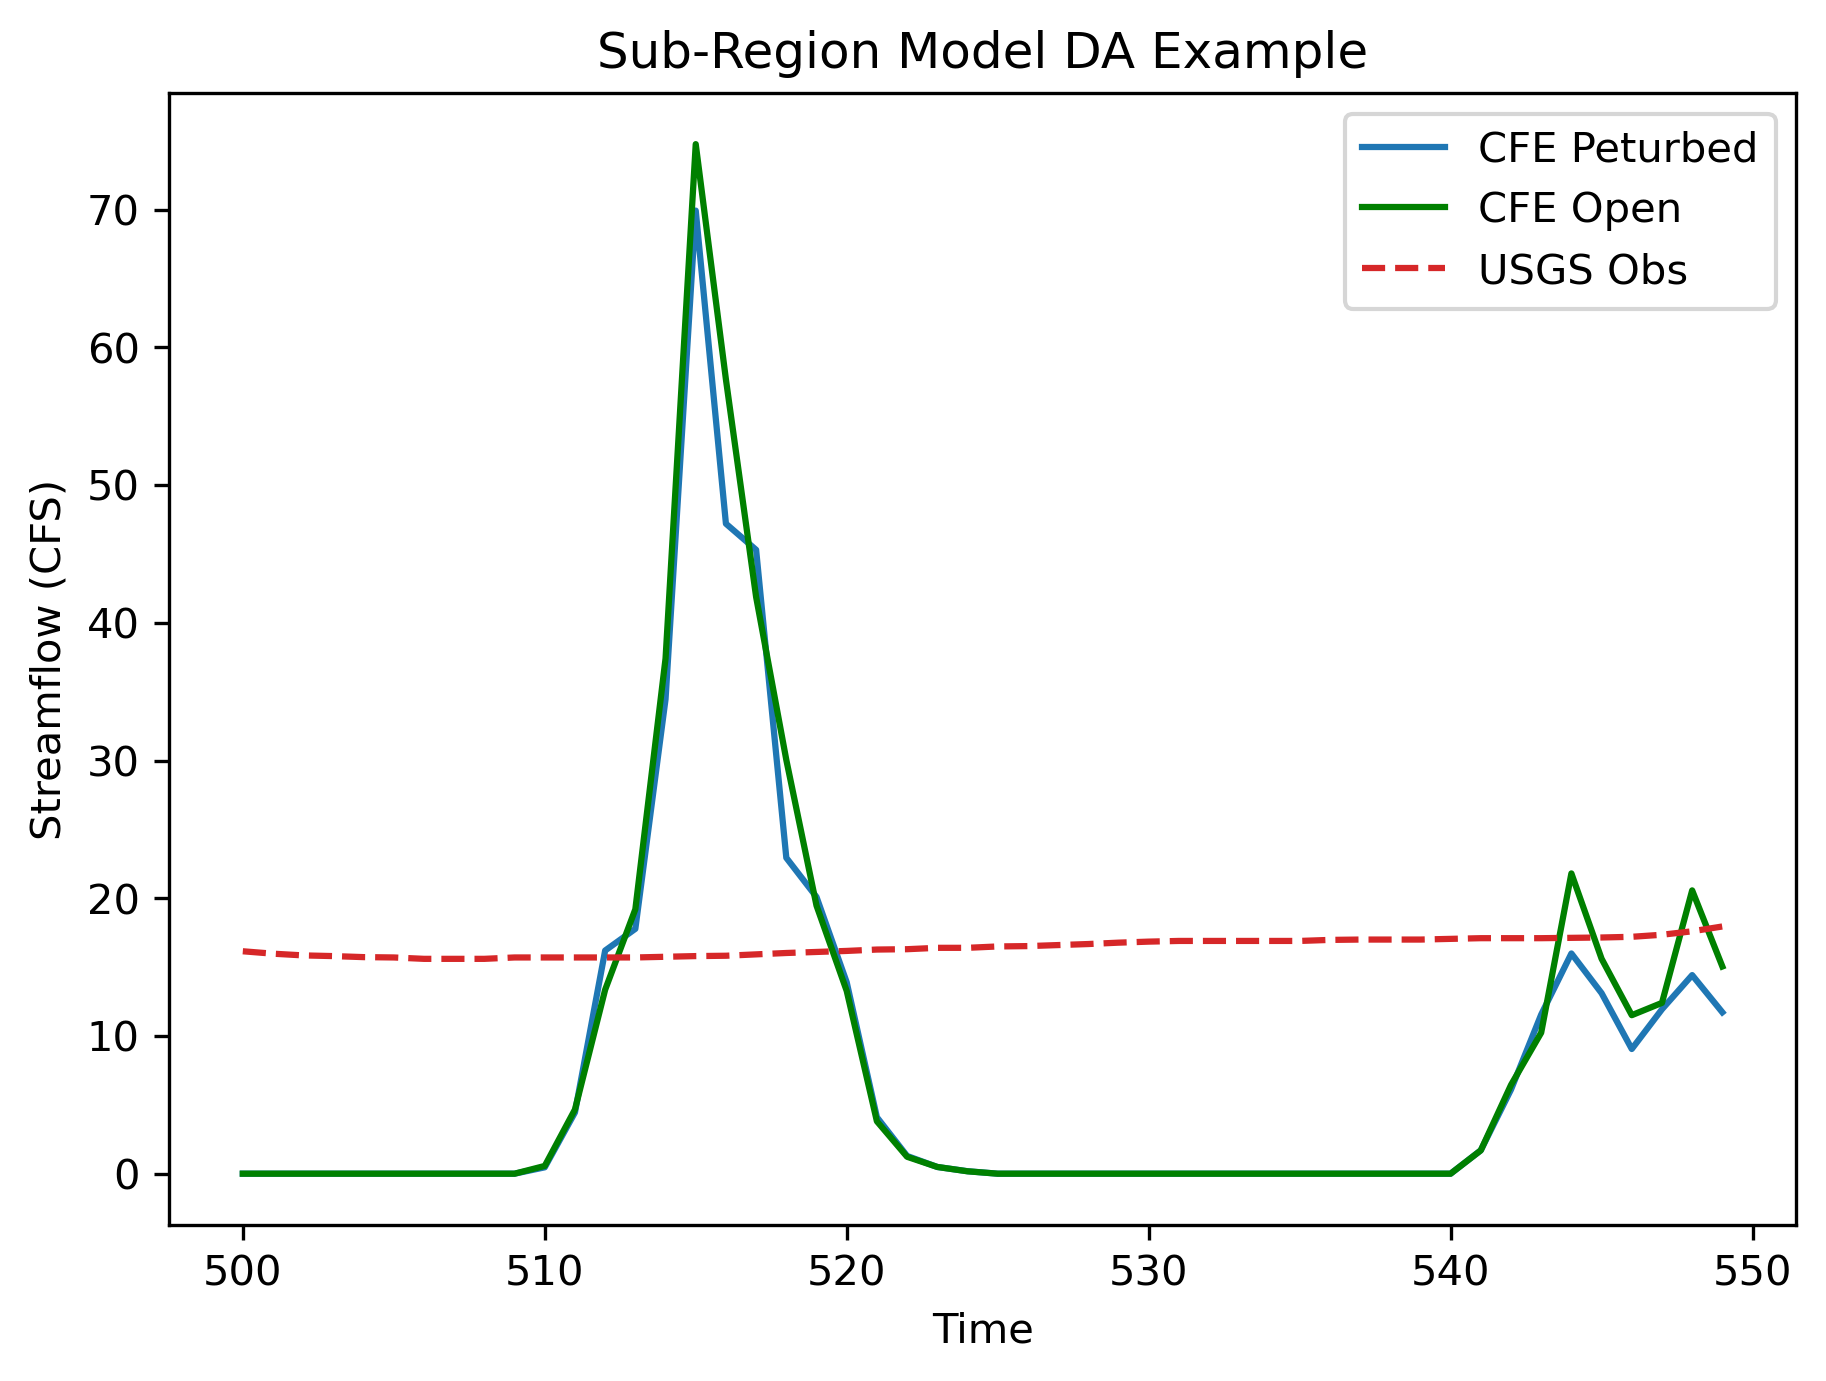

In [7]:
istart_plot=500
iend_plot=550
x = list(range(istart_plot, iend_plot))

fig = plt.figure(figsize = (7,5), dpi=300)

plt.title('Sub-Region Model DA Example')
plt.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:blue', label = 'CFE Peturbed')
plt.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
plt.plot(x, obs[istart_plot:iend_plot]*10, color = 'tab:red', linestyle='dashed', label = 'USGS Obs')
plt.ylabel('Streamflow (CFS)')
plt.xlabel('Time')
plt.legend()


In [8]:
# cfe_open = bmi_cfe()
# cfe_perturbed = bmi_cfe()
# cfe_analysis = bmi_cfe()
# enkf = bmi_enkf()
# usgs = bmi_usgs()

# cfe_open.initialize(‘config_open.yml’)
# cfe_perturbed.initialize(‘config_perturbed.yml’)
# cfe_analysis.initialize(‘config_analysis.yml’)
# enkf.initialize(‘config_enkf_cfe_basinID.yml’)
# usgs.initialize(‘config_basinID.yml’)

# For time in daterange():
#     forcing = forcings[time]
#     cfe_open.set_value(forcing)
#     cfe_perturbed.set_value(forcing)
#     cfe_analysis.set_value(forcing)
#     usgs.update()
#     obs = usgs.get_value()
#     cfe_open.update()
#     cfe_perturbed.update()
#     mean, variance  = cfe_perturbed.get_value()
#     enkf.set_value(obs, mean, variance )
#     state_transition = enkf.get_value()
#     cfe_analysis.set_value(state_transition)
#     cfe_analysis.update()
#     cfe_updated_everything = cfe_analysis.get_value(everything)
#     cfe_perturbed.set_value(cfe_updated_everything)
# cfe_open.initialize(‘config_open.yml’)
# cfe_perturbed.initialize(‘config_perturbed.yml’)
# cfe_analysis.initialize(‘config_analysis.yml’)
# enkf.initialize(‘config_enkf_cfe_basinID.yml’)
# usgs.initialize(‘config_basinID.yml’)